<a href="https://colab.research.google.com/github/adythiadean/Project/blob/master/Data_Challenge_Adythia_Dean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Challenge - Traveloka Customer Analysis

In this notebook we will work with a Traveloka customer lifecycle dataset. We will perform exploratory data analysis and visualisation to understand some characteristics from Traveloka customer and generate relevant strategies to improve the business

## Connecting to BigQuery and importing the data

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

project_id='tvlk-data-accom-dev'

Authenticated


In [0]:
# Import packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
#Query the data
from google.cloud import bigquery
client=bigquery.Client(project=project_id)

sql="""
    SELECT *
FROM `tvlk-data-mktscience-dev.data_challenge.customer_lifecycle`
"""

df=client.query(sql).to_dataframe()

In [0]:
# Display dataset dimension
print('Number of attributes/columns : {}' .format(df.shape[1]))
print('Number of rows : {}' .format(df.shape[0]))
print('Unique Profile ID : {} '.format(df['profile_id'].nunique()))

Number of attributes/columns : 42
Number of rows : 1672331
Unique Profile ID : 172233 


We can observe here that in the original dataset, each profile id may have multiple entries as the data capture user summary for each 'snapshot month'. We are more interested on latest data to know current condition of Traveloka customer, thus we need to revise the query

In [0]:
#Select only the latest data
sql="""
     select * except(rn) from
     (
     SELECT *,row_number() over(partition by profile_id order by snapshot_month desc) as rn
FROM `tvlk-data-mktscience-dev.data_challenge.customer_lifecycle`
      )
      where rn=1
"""
df_latest=client.query(sql).to_dataframe()

In [0]:
# Latest data only
print('Number of attributes/columns : {}' .format(df_latest.shape[1]))
print('Number of rows : {}' .format(df_latest.shape[0]))
print('Unique Profile ID : {} '.format(df_latest['profile_id'].nunique()))

Number of attributes/columns : 42
Number of rows : 172233
Unique Profile ID : 172233 


In this modified dataset, we have data consisting unique profile ID for each row on the latest snapshot month. We have now loaded the data, let's get a feeling of what the data looks like

In [0]:
df_latest.head(5)

,row_num,profile_id,last_ads_id,snapshot_month,churn_cut_off,first_issued_month,last_issued_month,lifecycle,bucket_gbv_usd_all,bucket_issued_1y,bucket_visit_1y,bucket_search_1y,bucket_gbv_1y,bucket_netrev_1y,bucket_coupon_1y,visit_count_all,search_count_all,issued_count_all,gbv_usd_all,net_revenue_usd_all,coupon_usage_usd_all,burnt_external_points_all,burnt_internal_points_all,earned_points_all,selling_points_all,country,is_registered,is_subscribed,issued_count,sum_gbv_usd,net_revenue_usd,search_count,visit_count,coupon_usage_usd,earned_points,burnt_internal_points,burnt_external_points,selling_points,is_customer,is_churn,product,product_breadth
0,1455216,10144,None,2015-12-01,0,None,None,00. known user,0,0,2,4,0,0,0,6.0,17.0,NaN,NaN,NaN,NaN,None,None,None,None,ID,False,0,NaN,NaN,NaN,17,3,NaN,None,None,None,None,False,False,all,0
1,1488411,10161,None,2015-12-01,0,None,None,00. known user,0,0,2,5,0,0,0,5.0,56.0,NaN,NaN,NaN,NaN,None,None,None,None,ID,False,0,NaN,NaN,NaN,0,0,NaN,None,None,None,None,False,False,all,0
2,359548,10174,None,2015-12-01,0,None,None,00. known user,0,0,2,2,0,0,0,6.0,3.0,NaN,NaN,NaN,NaN,None,None,None,None,ID,False,0,NaN,NaN,NaN,3,6,NaN,None,None,None,None,False,False,all,0
3,516062,11463,None,2015-12-01,0,None,None,00. known user,0,0,2,2,0,0,0,4.0,3.0,NaN,NaN,NaN,NaN,None,None,None,None,ID,False,0,NaN,NaN,NaN,0,0,NaN,None,None,None,None,False,False,all,0
4,1288749,80984,None,2015-12-01,0,2014-06-01,2014-08-01,11. hibernating,3,1,1,1,1,1,5,3.0,3.0,3.0,205.416,0.0,0.0,None,None,None,None,ID,False,0,0.0,0.0,0.0,0,0,0.0,None,None,None,None,True,True,all,1


In [0]:
#Descriptive statistics
df_latest.describe()

,row_num,profile_id,churn_cut_off,bucket_gbv_usd_all,bucket_issued_1y,bucket_visit_1y,bucket_search_1y,bucket_gbv_1y,bucket_netrev_1y,bucket_coupon_1y,visit_count_all,search_count_all,issued_count_all,gbv_usd_all,net_revenue_usd_all,coupon_usage_usd_all,is_subscribed,issued_count,sum_gbv_usd,net_revenue_usd,search_count,visit_count,coupon_usage_usd,product_breadth
count,1.722330e+05,1.722330e+05,172233.000000,172233.000000,172233.000000,172233.000000,172233.000000,172233.000000,172233.000000,172233.000000,159917.000000,157414.000000,129498.000000,129498.000000,129498.000000,129498.000000,172233.000000,129498.000000,129498.000000,129498.000000,172233.000000,172233.000000,129498.000000,172233.000000
mean,8.348213e+05,5.038983e+06,0.273676,2.288266,2.199352,2.296151,2.517561,2.482904,2.106286,3.511714,21.714877,30.872870,5.110210,435.832663,8.654726,-2.569641,0.090976,0.537885,50.265405,0.899145,5.269356,1.916514,-0.386578,0.873927
std,4.827266e+05,1.771408e+06,2.548207,1.746693,1.706439,0.957706,1.100677,1.843571,1.729441,2.176030,82.375558,126.319475,13.378052,1250.160036,43.712991,21.514756,0.300991,1.406852,174.439699,6.533699,43.251045,7.011533,3.220153,0.597716
min,2.000000e+01,1.000900e+04,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-5908.847651,-3396.100000,-1.000000,0.000000,0.000000,-163.230367,0.000000,0.000000,-181.804174,0.000000
25%,4.173900e+05,3.972845e+06,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,68.273225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,8.344030e+05,5.239904e+06,0.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,5.000000,4.000000,4.000000,2.000000,165.828000,3.296425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.253962e+06,6.425150e+06,0.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,5.000000,15.000000,21.000000,5.000000,421.594842,10.559825,0.000000,0.000000,1.000000,28.433500,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.672317e+06,1.110133e+07,24.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,8804.000000,10450.000000,1256.000000,173022.507957,3704.895207,0.000000,1.000000,65.000000,10511.257300,329.578214,10404.000000,565.000000,0.000000,3.000000


In [0]:
#Check missing data
total = df_latest.isnull().sum().sort_values(ascending=False)
percent = (df_latest.isnull().sum()/df_latest.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
selling_points,172233,100.000000
burnt_external_points,172233,100.000000
burnt_internal_points,172233,100.000000
earned_points,172233,100.000000
burnt_external_points_all,172233,100.000000
burnt_internal_points_all,172233,100.000000
earned_points_all,172233,100.000000
selling_points_all,172233,100.000000
last_ads_id,112527,65.334169
coupon_usage_usd_all,42735,24.812318


By checking numbers of null entries for each column in the dataset, it can be observed that columns related to Traveloka points all have null values and thus cannot be used in the analysis. Another interesting thing is all columns related to purchase summary (issued_count, gbv_usd_all,etc) has exactly same number of null entries. Why is that?

In [0]:
summ=df_latest.groupby('lifecycle')['profile_id'].count().reset_index()
summ['Percentage'] = 100 * summ['profile_id']  / summ['profile_id'].sum()
summ

,lifecycle,profile_id,Percentage
0,00. known user,42735,24.812318
1,01. first time customer,12131,7.043366
2,02. recent customer,17722,10.289550
3,03. promising customer,25005,14.518124
4,04. potential loyalist,12477,7.244256
5,05. loyal customer,8958,5.201094
6,06. champions,18280,10.613529
7,07. need attention,1839,1.067740
8,08. about to sleep,19029,11.048405
9,09. at risk,1164,0.675829


We found that one of lifecycle class, "known user" has same number of entries with number of null entries from purchase-related columns (42375), and from further check it is confirmed that all purchase-related columns in this class has null values. It can be concluded that this segment is segment who never made any issuance, hence null values for purchase summary data.

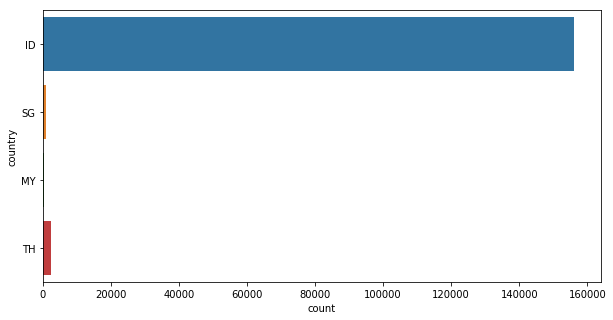

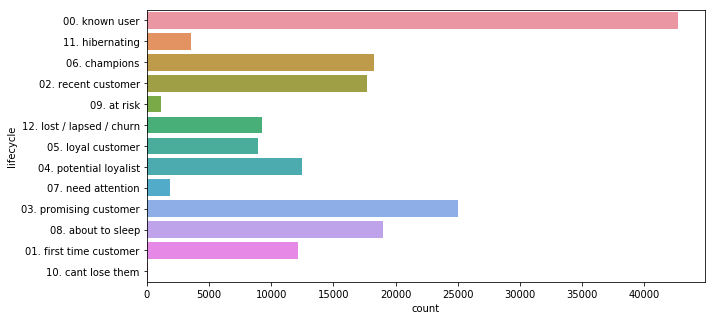

In [0]:
# Count plot by lifecycle
plt.figure(1 , figsize = (10 , 5))
sns.countplot(y = 'lifecycle' , data = df_latest)
plt.show()

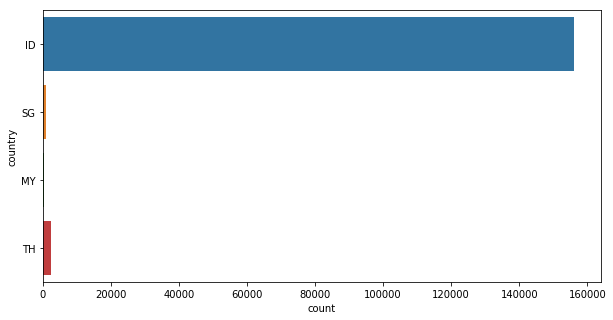

In [0]:
# Count plot by country
plt.figure(1 , figsize = (10 , 5))
sns.countplot(y = 'country' , data = df_latest)
plt.show()

#Further visualization will be done in Tableau workbook

 # Presentation

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


https://docs.google.com/presentation/d/1Lx1-9gzBvE1gXH76mW5Sjh2tvmtqg-034AeXa2BYSUo/edit?usp=sharing